# Secuential Monte Carlo

In [8]:
# Import all the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from scipy.integrate import odeint

In [81]:
def sir_model(params, t, N):
    beta, gamma, mu = params
    S = np.zeros_like(t, dtype=float)
    I = np.zeros_like(t, dtype=float)
    R = np.zeros_like(t, dtype=float)
    D = np.zeros_like(t, dtype=float)

    S[0] = N - 1  # Initial susceptible population
    I[0] = 1      # Initial infected population

    for i in range(1, len(t)):
        dS = -beta * S[i - 1] * I[i - 1] / N
        dI = (beta * S[i - 1] * I[i - 1] / N) - gamma * I[i - 1] - mu * I[i - 1]
        dR = gamma * I[i - 1]
        dD = mu * I[i - 1]

        S[i] = S[i - 1] + dS
        I[i] = I[i - 1] + dI
        R[i] = R[i - 1] + dR
        D[i] = D[i - 1] + dD

    return S, I, R, D


# Define the uninformative prior distribution
def prior(params):
    # Use uniform priors for beta and gamma
    beta, gamma, mu = params
    if 0.000001< beta <0.1 and 0.01< gamma <0.2 and 0.0001< mu <0.1:
        return 0  # Priors within bounds
    else:
        return -np.inf  # Priors outside bounds
    

def likelihood(params, observed_data, t, N):
    _, _, _, D = sir_model(params, t, N)
    
    # Assuming a Poisson likelihood
    log_likelihood = np.sum(observed_data * np.log(D) - D)
    
    return log_likelihood


def metropolis_hastings(initial_params, observed_data, t, N, num_samples, proposal_stddev):
    # Initialize the current parameters and log-likelihood
    current_params = initial_params
    current_log_likelihood = likelihood(initial_params, observed_data, t, N) + prior(initial_params)
    
    # Initialize lists to store samples
    samples = [current_params]
    acceptance_rates = []

    # Perform MCMC sampling
    for _ in range(num_samples):
        # Propose a new set of parameters
        proposed_params = current_params + proposal_stddev * np.random.randn(len(current_params))

        # Compute the log-likelihood of the proposed parameters
        proposed_log_likelihood = likelihood(proposed_params, observed_data, t, N) + prior(proposed_params)

        # Calculate the acceptance ratio
        acceptance_ratio = min(1, np.exp(proposed_log_likelihood - current_log_likelihood))

        # Accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
            current_params = proposed_params
            current_log_likelihood = proposed_log_likelihood
            samples.append(current_params)
            acceptance_rates.append(1)
        else:
            samples.append(current_params)
            acceptance_rates.append(0)

    return np.array(samples), np.array(acceptance_rates)


In [82]:
# Define your SIRD model function as a system of ODEs
def sird_model2(y, t, beta, gamma, mu):
    S, I, R, D = y
    dS = -beta * S * I
    dI = beta * S * I - (gamma + mu) * I
    dR = gamma * I
    dD = mu * I
    return [dS, dI, dR, dD]

# Define initial conditions and parameters
N = 1000
y0 = [N - 1, 1, 0, 0]  # Initial values of S, I, R, D
t = np.arange(0, 50)
params = [1/1000, 1/15, 0.015]

# Use odeint to solve the ODEs
sol = odeint(sird_model2, y0, t, args=tuple(params))
S, I, R, D = sol.T  # Extract the solution

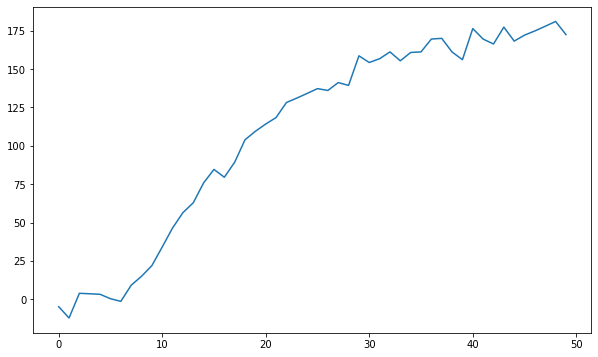

In [83]:
observed_data = D + np.random.normal(scale = D.std()/15, size = D.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(observed_data)
plt.show()


In [91]:
# Define your observed data and other parameters
t = np.arange(0, len(observed_data))
initial_params = [0.015, 0.015, .0015]
num_samples = 200000  # Number of MCMC samples
proposal_stddev = [15/100000, 1/1500, 80/1000000]

# Perform MH MCMC sampling
samples, acceptance_rates = metropolis_hastings(initial_params, observed_data, t, N, num_samples, proposal_stddev)

# Burn-in and thinning (optional)
burn_in = 10000
thinning = 10000
burned_in_samples = samples[burn_in::thinning]

# Compute posterior statistics (mean, median, etc.) using the samples
posterior_mean = np.mean(burned_in_samples, axis=0)
posterior_median = np.median(burned_in_samples, axis=0)

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_45071/2640334349.py:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(observed_data * np.log(D) - D)
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_45071/2640334349.py:62: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_ratio = min(1, np.exp(proposed_log_likelihood - current_log_likelihood))
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_45071/2640334349.py:59: RuntimeWarning: invalid value encountered in double_scalars
  proposed_log_likelihood = likelihood(proposed_params, observed_data, t, N) + prior(proposed_params)
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_45071/2640334349.py:39: RuntimeWarning: invalid value encountered in log
  log_likelihood = np.sum(observed_data * np.log(D) - D)


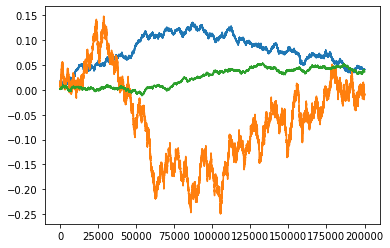

In [92]:
plt.plot(samples)
plt.show()

In [93]:
posterior_median

array([ 0.08500309, -0.05648888,  0.03301853])